In [1]:
import types

from botocore.client import Config
import ibm_boto3

import numpy as np # library to handle data in a vectorized manner

import pandas as pd 
import requests
import lxml
import csv
from collections import Counter

!conda install -c conda-forge folium=0.5.0 --yes 
import folium #library for making maps
from geopy.geocoders import Nominatim
import json # library to handle JSON files
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

#### Import the top cities in India  according to the website 
https://www.travelogyindia.com/blog/the-top-20-must-visit-cities-in-india

In [2]:
# The code was removed by Watson Studio for sharing.

,Cities
0,Udaipur
1,Bhubaneswar
2,Kodaikanal
3,Darjeeling
4,Havelock Island
5,Khajjiar
6,Aurangabad
7,Varanasi
8,Agra
9,Amritsar


In [3]:
geolocator = Nominatim()
India_tourist_cities_df_with_xy = India_tourist_cities_df.copy()

latlon = India_tourist_cities_df_with_xy.Cities.apply(lambda addr: geolocator.geocode(addr))

India_tourist_cities_df_with_xy["Latitude"] = [x.latitude for x in latlon]
India_tourist_cities_df_with_xy["Longitude"] = [x.longitude for x in latlon]

In [5]:
India_tourist_cities_df_with_xy.head(25)

,Cities,Latitude,Longitude
0,Udaipur,24.578721,73.686257
1,Bhubaneswar,20.266567,85.843759
2,Kodaikanal,10.235117,77.493831
3,Darjeeling,26.682113,88.329069
4,Havelock Island,11.965195,92.995621
5,Khajjiar,32.548570,76.059722
6,Aurangabad,24.750000,84.500000
7,Varanasi,25.335649,83.007629
8,Agra,27.175255,78.009816
9,Amritsar,31.634308,74.873679


In [4]:
# Save collected food venues by city into csv for future use
India_tourist_cities_df_with_xy.to_csv("India_tourist_cities_df_with_xy.csv")

In [6]:
#Generate map for India
longitude = 21.7679
latitude = 78.8718
map_India = folium.Map(location=[longitude, latitude], zoom_start=5.2)
map_India

In [8]:
for lat, lng, neighborhood in zip(India_tourist_cities_df_with_xy['Latitude'], India_tourist_cities_df_with_xy['Longitude'],
                                  India_tourist_cities_df_with_xy['Cities']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_India)  
    
map_India

In [9]:
#Pass the coordinates to Foursquare
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT='30'

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Name', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByCategory(names, latitudes, longitudes, categoryID, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['City','City Latitude','City Longitude','VenueID','VenueName','score','category','catID','latitude','longitude']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
#       cyclefsk2()
        print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
        url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,categoryID)
        # make the GET request
        results = requests.get(url).json()
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
        
        for jsonSub in results['response']['venues']:
            #print(jsonSub)
            # JSON Results may not be in expected format or incomplete data, in that case, skip!
            ven_id = 0
            try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                ven_id   = jsonSub['id']
                ven_cat  = jsonSub['categories'][0]['pluralName']
                ven_CID  = jsonSub['categories'][0]['id']
                ven_name = jsonSub['name']
                ven_lat  = jsonSub['location']['lat']
                ven_lng  = jsonSub['location']['lng']
                venue_DF = venue_DF.append({
                    'City'      : name,
                    'City Latitude' : lat,
                    'City Longitude': lng,
                    'VenueID'   : ven_id,
                    'VenueName' : ven_name,
                    'score'     : 'nan',
                    'category'  : ven_cat,
                    'catID'     : ven_CID,
                    'latitude'  : ven_lat,
                    'longitude' : ven_lng}, ignore_index=True)
            except:
                continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

In [12]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID','Score']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesIDScore(venueID):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    global venue_id_recover
    print("[#getVenuesIDScore]")
    venID_URL = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueID,CLIENT_ID,CLIENT_SECRET,VERSION)
    print(venID_URL)
    venID_score = 0.00
    # Process results
    try:
        venID_result = requests.get(venID_URL).json()
        venID_score  = venID_result['response']['venue']['rating']
    except: 
        #venue_id_recover = venue_id_recover.append({'VenueID' : venueID, 'Score' : 0.0})
        print('This venue has not been rated yet or quota_exceeded')
        #return ["error",0.0]
    
    return ["success",venID_score]

In [13]:
#Create a dataframe
venue_columns = ['City','City Latitude','City Longitude','VenueID','VenueName','Score','Category','CatID','Latitude','Longitude']
India_city_venues = pd.DataFrame(columns=venue_columns)
India_city_venues

,City,City Latitude,City Longitude,VenueID,VenueName,Score,Category,CatID,Latitude,Longitude


In [14]:
#Search Venues with recommendations on : Historic Venues 
 #Historic Site: 4deefb944765f83613cdba6e
categoryID = "4deefb944765f83613cdba6e" # See a list of category ID's athttps://developer.foursquare.com/docs/resources/categories
city_names = India_tourist_cities_df_with_xy['Cities']
lat_list   = India_tourist_cities_df_with_xy['Latitude']
lng_list   = India_tourist_cities_df_with_xy['Longitude']
India_city_historic_venues = getVenuesByCategory(names=city_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

[#Start getVenuesByCategory]
Udaipur ,Bhubaneswar ,Kodaikanal ,Darjeeling ,Havelock Island ,Khajjiar ,Aurangabad ,Varanasi ,Agra ,Amritsar ,Madurai ,Kochi ,Bengaluru ,Mumbai ,Jaipur ,Sri Nagar ,Shimla ,Hyderabad ,Chennai ,Pondicherry ,
[#Done getVenuesByCategory]


In [15]:
India_city_historic_venues['Primary_category'] = "Historic Sites"
India_city_historic_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4bc2b8a4abf495218ce8c293,City Palace Museum,nan,Museums,4bf58dd8d48988d181941735,24.576911,73.683544,Historic Sites
1,Udaipur,24.578721,73.686257,5bee895e1953f3002c19955c,Chini Chitrashala,nan,Historic Sites,4deefb944765f83613cdba6e,24.576450,73.683530,Historic Sites
2,Udaipur,24.578721,73.686257,5bee89c073fe25002cc8d5da,Mor Chowk,nan,Historic Sites,4deefb944765f83613cdba6e,24.576523,73.683416,Historic Sites
3,Udaipur,24.578721,73.686257,5bee6f421953f3002c003e99,Badi Mahal,nan,Gardens,4bf58dd8d48988d15a941735,24.577316,73.683452,Historic Sites
4,Udaipur,24.578721,73.686257,56ae2a19498e71625c63a461,Manek Chowk,nan,Historic Sites,4deefb944765f83613cdba6e,24.576747,73.683902,Historic Sites


In [16]:
# Save collected historic site venues by city into csv for future use
India_city_historic_venues.to_csv("India_city_historic_venues.csv")

In [17]:
#Search Venues with recommendations on : Food ( Restaurants)
#Food : 4d4b7105d754a06374d81259
categoryID = "4d4b7105d754a06374d81259" # See a list of category ID's athttps://developer.foursquare.com/docs/resources/categories
city_names = India_tourist_cities_df_with_xy['Cities']
lat_list   = India_tourist_cities_df_with_xy['Latitude']
lng_list   = India_tourist_cities_df_with_xy['Longitude']
India_city_Food_venues = getVenuesByCategory(names=city_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

[#Start getVenuesByCategory]
Udaipur ,Bhubaneswar ,Kodaikanal ,Darjeeling ,Havelock Island ,Khajjiar ,Aurangabad ,Varanasi ,Agra ,Amritsar ,Madurai ,Kochi ,Bengaluru ,Mumbai ,Jaipur ,Sri Nagar ,Shimla ,Hyderabad ,Chennai ,Pondicherry ,
[#Done getVenuesByCategory]


In [18]:
India_city_Food_venues['Primary_category'] = "Food"
India_city_Food_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4f436c61e4b043515299f96f,Lotus Cafe & Restaurant,nan,Indian Restaurants,4bf58dd8d48988d10f941735,24.578519,73.685084,Food
1,Udaipur,24.578721,73.686257,4ed216fc775bbb5f34ea16e1,Mayur Cafe,nan,Indian Restaurants,4bf58dd8d48988d10f941735,24.579761,73.684331,Food
2,Udaipur,24.578721,73.686257,4e1befa06284102ec1987fa1,Govinda's Cafeteria,nan,Cafés,4bf58dd8d48988d16d941735,24.578935,73.683712,Food
3,Udaipur,24.578721,73.686257,52f609ae498ee624b43a0d02,Veg Restaurant,nan,Indian Restaurants,4bf58dd8d48988d10f941735,24.578891,73.683865,Food
4,Udaipur,24.578721,73.686257,5040bac2e4b01c1808e1d40e,O'Zen,nan,American Restaurants,4bf58dd8d48988d14e941735,24.579521,73.683791,Food


In [21]:
# Save collected food venues by city into csv for future use
India_city_Food_venues.to_csv("India_city_Food_venues.csv")

In [22]:
#Search Venues with recommendations on : Travel & Transport ( Airport, Hotels, Bus, Train)
#Travel & Transport : 4d4b7105d754a06379d81259
categoryID = "4d4b7105d754a06379d81259" # See a list of category ID's athttps://developer.foursquare.com/docs/resources/categories
city_names = India_tourist_cities_df_with_xy['Cities']
lat_list   = India_tourist_cities_df_with_xy['Latitude']
lng_list   = India_tourist_cities_df_with_xy['Longitude']
India_city_Travel_Transport_venues = getVenuesByCategory(names=city_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

India_city_Travel_Transport_venues['Primary_category'] = "Travel"
India_city_Travel_Transport_venues.head()

[#Start getVenuesByCategory]
Udaipur ,Bhubaneswar ,Kodaikanal ,Darjeeling ,Havelock Island ,Khajjiar ,Aurangabad ,Varanasi ,Agra ,Amritsar ,Madurai ,Kochi ,Bengaluru ,Mumbai ,Jaipur ,Sri Nagar ,Shimla ,Hyderabad ,Chennai ,Pondicherry ,
[#Done getVenuesByCategory]


,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,5b9526a3db2aeb002c1692b7,The Neem Tree,nan,Hotels,4bf58dd8d48988d1fa931735,24.578620,73.685870,Travel
1,Udaipur,24.578721,73.686257,5061acd8e4b0293cde4f6c2d,Hotel Kiran Palace,nan,Hotels,4bf58dd8d48988d1fa931735,24.578550,73.685113,Travel
2,Udaipur,24.578721,73.686257,4ef89549d3e354f0be0ffca6,Krishna Palace,nan,Motels,4bf58dd8d48988d1fb931735,24.583656,73.683704,Travel
3,Udaipur,24.578721,73.686257,563e0c6638faa20ddb10af4a,Little Garden Guesthouse,nan,Hotels,4bf58dd8d48988d1fa931735,24.577294,73.684762,Travel
4,Udaipur,24.578721,73.686257,5657220e498edfd40c20f045,Art of Bicycle Trips,nan,Bike Rentals / Bike Shares,4e4c9077bd41f78e849722f9,24.578369,73.682561,Travel


In [23]:
# Save collected transport venues by city into csv for future use
India_city_Travel_Transport_venues.to_csv("India_city_Travel_Transport_venues.csv")

In [24]:
#Search Venues with recommendations on : Spiritual Center ( Temples, Gurdwaras)
#Spiritual Center : 4bf58dd8d48988d131941735
categoryID = "4bf58dd8d48988d131941735" # See a list of category ID's athttps://developer.foursquare.com/docs/resources/categories
city_names = India_tourist_cities_df_with_xy['Cities']
lat_list   = India_tourist_cities_df_with_xy['Latitude']
lng_list   = India_tourist_cities_df_with_xy['Longitude']
India_city_Temple_venues = getVenuesByCategory(names=city_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

India_city_Temple_venues['Primary_category'] = "Temples"
India_city_Temple_venues.head()

[#Start getVenuesByCategory]
Udaipur ,Bhubaneswar ,Kodaikanal ,Darjeeling ,Havelock Island ,Khajjiar ,Aurangabad ,Varanasi ,Agra ,Amritsar ,Madurai ,Kochi ,Bengaluru ,Mumbai ,Jaipur ,Sri Nagar ,Shimla ,Hyderabad ,Chennai ,Pondicherry ,
[#Done getVenuesByCategory]


,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4d1ed2ba756e8cfa35415e54,Jagdish Temple,nan,Temples,4bf58dd8d48988d13a941735,24.579725,73.684030,Temples
1,Udaipur,24.578721,73.686257,51f902aa498ea534c846f5f1,Radha Vallabh Ji Ka Mandir,nan,Temples,4bf58dd8d48988d13a941735,24.581560,73.682946,Temples
2,Udaipur,24.578721,73.686257,4e3a607fd4c05163b44f1183,Mata Tripureshwari Temple,nan,Temples,4bf58dd8d48988d13a941735,24.580380,73.683124,Temples
3,Bhubaneswar,20.266567,85.843759,542b9913498efa8eed728721,Kali Bari,nan,Hindu Temples,52e81612bcbc57f1066b7a3f,20.263263,85.840158,Temples
4,Bhubaneswar,20.266567,85.843759,4f237c91e4b03bdcfbdd8bbc,Jageshwara Temple,nan,Temples,4bf58dd8d48988d13a941735,20.265113,85.839188,Temples


In [25]:
# Save collected Spiritual Center venues by city into csv for future use
India_city_Temple_venues.to_csv("India_city_Temple_venues.csv")

In [26]:
#Main Dataframe : India_tourist_cities_df_with_xy

# Dataframes for different Categories
#India_city_historic_venues : Historic Site
print("India_city_historic_venues",India_city_historic_venues.shape)
#India_city_Food_venues : Food
print("India_city_Food_venues", India_city_Food_venues.shape)
#India_city_Travel_Transport_venues : Travel & Transport
print("India_city_Travel_Transport_venues", India_city_Travel_Transport_venues.shape)
#India_city_Temple_venues : Spritual Center
print("India_city_Temple_venues", India_city_Temple_venues.shape)

India_city_historic_venues (23, 11)
India_city_Food_venues (316, 11)
India_city_Travel_Transport_venues (207, 11)
India_city_Temple_venues (59, 11)


##### Since there is a limit of 500 calls per day for the free subscription, cannot call this API for all the venues in the above 4 data frames. Hence generating a random number for Score field

In [36]:
#This code works fine when uncommented.
# Get venue details for each dataframe and fetch the venue rating for the "score"

#score_is_NAN = len(NL_city_food_venues[NL_city_food_venues['score'].isnull()].index.tolist())
#print("Current score=NaN count=",score_is_NAN)
#
#for idx in NL_city_food_venues['score'].isnull().index.tolist():
#    venueID = NL_city_food_venues.loc[idx,'VenueID']
#    print (venueID)
#    status,score = getVenuesIDScore(venueID)
#    if status == "success":
#        NL_city_food_venues.loc[idx,'score'] = score
#        
#score_is_NAN = len(NL_city_food_venues[NL_city_food_venues['score'].isnull()].index.tolist())
#print("PostRun score=NaN count=",score_is_NAN)
#print('Done',end='')

##### Generate random recommendation score for all venues dataframes

In [27]:
# Generate random recommendation score for Historic Sites venues
India_city_historic_venues['score'] = np.random.uniform(4.0,9.5, size=len(India_city_historic_venues)).astype(float).round(1)
India_city_historic_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4bc2b8a4abf495218ce8c293,City Palace Museum,9.4,Museums,4bf58dd8d48988d181941735,24.576911,73.683544,Historic Sites
1,Udaipur,24.578721,73.686257,5bee895e1953f3002c19955c,Chini Chitrashala,6.4,Historic Sites,4deefb944765f83613cdba6e,24.576450,73.683530,Historic Sites
2,Udaipur,24.578721,73.686257,5bee89c073fe25002cc8d5da,Mor Chowk,8.2,Historic Sites,4deefb944765f83613cdba6e,24.576523,73.683416,Historic Sites
3,Udaipur,24.578721,73.686257,5bee6f421953f3002c003e99,Badi Mahal,6.7,Gardens,4bf58dd8d48988d15a941735,24.577316,73.683452,Historic Sites
4,Udaipur,24.578721,73.686257,56ae2a19498e71625c63a461,Manek Chowk,4.8,Historic Sites,4deefb944765f83613cdba6e,24.576747,73.683902,Historic Sites


In [28]:
# Generate random recommendation score for Food venues
India_city_Food_venues['score'] = np.random.uniform(4.0,9.5, size=len(India_city_Food_venues )).astype(float).round(1)
India_city_Food_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4f436c61e4b043515299f96f,Lotus Cafe & Restaurant,8.1,Indian Restaurants,4bf58dd8d48988d10f941735,24.578519,73.685084,Food
1,Udaipur,24.578721,73.686257,4ed216fc775bbb5f34ea16e1,Mayur Cafe,6.3,Indian Restaurants,4bf58dd8d48988d10f941735,24.579761,73.684331,Food
2,Udaipur,24.578721,73.686257,4e1befa06284102ec1987fa1,Govinda's Cafeteria,7.3,Cafés,4bf58dd8d48988d16d941735,24.578935,73.683712,Food
3,Udaipur,24.578721,73.686257,52f609ae498ee624b43a0d02,Veg Restaurant,4.4,Indian Restaurants,4bf58dd8d48988d10f941735,24.578891,73.683865,Food
4,Udaipur,24.578721,73.686257,5040bac2e4b01c1808e1d40e,O'Zen,8.3,American Restaurants,4bf58dd8d48988d14e941735,24.579521,73.683791,Food


In [29]:
# Generate random recommendation score for Travel and Transport venues
India_city_Travel_Transport_venues['score'] = np.random.uniform(4.0,9.5, size=len(India_city_Travel_Transport_venues)).astype(float).round(1)
India_city_Travel_Transport_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,5b9526a3db2aeb002c1692b7,The Neem Tree,7.3,Hotels,4bf58dd8d48988d1fa931735,24.578620,73.685870,Travel
1,Udaipur,24.578721,73.686257,5061acd8e4b0293cde4f6c2d,Hotel Kiran Palace,4.6,Hotels,4bf58dd8d48988d1fa931735,24.578550,73.685113,Travel
2,Udaipur,24.578721,73.686257,4ef89549d3e354f0be0ffca6,Krishna Palace,6.0,Motels,4bf58dd8d48988d1fb931735,24.583656,73.683704,Travel
3,Udaipur,24.578721,73.686257,563e0c6638faa20ddb10af4a,Little Garden Guesthouse,8.9,Hotels,4bf58dd8d48988d1fa931735,24.577294,73.684762,Travel
4,Udaipur,24.578721,73.686257,5657220e498edfd40c20f045,Art of Bicycle Trips,7.6,Bike Rentals / Bike Shares,4e4c9077bd41f78e849722f9,24.578369,73.682561,Travel


In [30]:
# Generate random recommendation score for Spiritual Center venues
India_city_Temple_venues['score'] = np.random.uniform(4.0,9.5, size=len(India_city_Temple_venues)).astype(float).round(1)
India_city_Temple_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4d1ed2ba756e8cfa35415e54,Jagdish Temple,7.2,Temples,4bf58dd8d48988d13a941735,24.579725,73.684030,Temples
1,Udaipur,24.578721,73.686257,51f902aa498ea534c846f5f1,Radha Vallabh Ji Ka Mandir,8.1,Temples,4bf58dd8d48988d13a941735,24.581560,73.682946,Temples
2,Udaipur,24.578721,73.686257,4e3a607fd4c05163b44f1183,Mata Tripureshwari Temple,8.9,Temples,4bf58dd8d48988d13a941735,24.580380,73.683124,Temples
3,Bhubaneswar,20.266567,85.843759,542b9913498efa8eed728721,Kali Bari,6.9,Hindu Temples,52e81612bcbc57f1066b7a3f,20.263263,85.840158,Temples
4,Bhubaneswar,20.266567,85.843759,4f237c91e4b03bdcfbdd8bbc,Jageshwara Temple,6.0,Temples,4bf58dd8d48988d13a941735,20.265113,85.839188,Temples


##### Merge all 4 dataframes to the  main dataframe we prepared above

In [31]:
# Combine all categories with scores
India_city_venues = pd.concat([India_city_historic_venues, 
                            India_city_Food_venues,
                            India_city_Travel_Transport_venues,
                            India_city_Temple_venues], ignore_index=True)
India_city_venues.shape

(605, 11)

In [32]:
India_city_venues.head()

,City,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
0,Udaipur,24.578721,73.686257,4bc2b8a4abf495218ce8c293,City Palace Museum,9.4,Museums,4bf58dd8d48988d181941735,24.576911,73.683544,Historic Sites
1,Udaipur,24.578721,73.686257,5bee895e1953f3002c19955c,Chini Chitrashala,6.4,Historic Sites,4deefb944765f83613cdba6e,24.576450,73.683530,Historic Sites
2,Udaipur,24.578721,73.686257,5bee89c073fe25002cc8d5da,Mor Chowk,8.2,Historic Sites,4deefb944765f83613cdba6e,24.576523,73.683416,Historic Sites
3,Udaipur,24.578721,73.686257,5bee6f421953f3002c003e99,Badi Mahal,6.7,Gardens,4bf58dd8d48988d15a941735,24.577316,73.683452,Historic Sites
4,Udaipur,24.578721,73.686257,56ae2a19498e71625c63a461,Manek Chowk,4.8,Historic Sites,4deefb944765f83613cdba6e,24.576747,73.683902,Historic Sites


#### Group By city name to get the venue count for each city

In [57]:
India_city_venues.groupby('City').count()

,City Latitude,City Longitude,VenueID,VenueName,score,category,catID,latitude,longitude,Primary_category
City,,,,,,,,,,
Agra,11,11,11,11,11,11,11,11,11,11
Amritsar,53,53,53,53,53,53,53,53,53,53
Bengaluru,21,21,21,21,21,21,21,21,21,21
Bhubaneswar,45,45,45,45,45,45,45,45,45,45
Chennai,7,7,7,7,7,7,7,7,7,7
Darjeeling,15,15,15,15,15,15,15,15,15,15
Hyderabad,39,39,39,39,39,39,39,39,39,39
Jaipur,25,25,25,25,25,25,25,25,25,25
Khajjiar,7,7,7,7,7,7,7,7,7,7


In [33]:
print('There are {} uniques venue categories.'.format(len(India_city_venues['category'].unique())))

There are 97 uniques venue categories.


In [34]:
# one hot encoding
India_city_onehot = pd.get_dummies(India_city_venues[['category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
India_city_onehot['City'] = India_city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [India_city_onehot.columns[-1]] + list(India_city_onehot.columns[:-1])
India_city_onehot = India_city_onehot[fixed_columns]

India_city_onehot.head()

,City,Airport Food Courts,Airport Gates,Airport Services,Airport Terminals,Airports,American Restaurants,Asian Restaurants,BBQ Joints,Baggage Claims,...,Spiritual Centers,Tea Rooms,Temples,Theme Restaurants,Tourist Information Centers,Train Stations,Transportation Services,Travel Lounges,Vacation Rentals,Vegetarian / Vegan Restaurants
0,Udaipur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Udaipur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Udaipur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Udaipur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Udaipur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#Find mean value for each category
India_city_grouped = India_city_onehot.groupby('City').mean().reset_index()
India_city_grouped

,City,Airport Food Courts,Airport Gates,Airport Services,Airport Terminals,Airports,American Restaurants,Asian Restaurants,BBQ Joints,Baggage Claims,...,Spiritual Centers,Tea Rooms,Temples,Theme Restaurants,Tourist Information Centers,Train Stations,Transportation Services,Travel Lounges,Vacation Rentals,Vegetarian / Vegan Restaurants
0,Agra,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000
1,Amritsar,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.018868,0.000000,0.000000,...,0.018868,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868
2,Bengaluru,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.047619,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bhubaneswar,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.022222,0.000000,0.000000,...,0.000000,0.000000,0.044444,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.022222
4,Chennai,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
5,Darjeeling,0.066667,0.133333,0.266667,0.4,0.066667,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Hyderabad,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.025641,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Jaipur,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Khajjiar,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Kochi,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
#Print 5 most common venues
num_top_venues = 5

for hood in India_city_grouped['City']:
    print("----"+hood+"----")
    temp = India_city_grouped[India_city_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agra----
                venue  freq
0              Hotels  0.27
1  Indian Restaurants  0.09
2      Travel Lounges  0.09
3  Indian Sweet Shops  0.09
4      General Travel  0.09


----Amritsar----
                   venue  freq
0                 Hotels  0.26
1     Indian Restaurants  0.21
2          Dessert Shops  0.06
3  Fast Food Restaurants  0.06
4               Bakeries  0.04


----Bengaluru----
                venue  freq
0              Hotels  0.19
1  Indian Restaurants  0.10
2          Cafeterias  0.10
3         Food Trucks  0.10
4        Pizza Places  0.05


----Bhubaneswar----
                venue  freq
0              Hotels  0.29
1  Indian Restaurants  0.11
2           Platforms  0.07
3         Restaurants  0.04
4             Temples  0.04


----Chennai----
                      venue  freq
0        Indian Restaurants  0.29
1           Ice Cream Shops  0.14
2            Train Stations  0.14
3                  Churches  0.14
4  South Indian Restaurants  0.14


----Darjeeli

In [40]:
# Sort in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
India_city_venues_sorted = pd.DataFrame(columns=columns)
India_city_venues_sorted['City'] = India_city_grouped['City']

for ind in np.arange(India_city_grouped.shape[0]):
    India_city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(India_city_grouped.iloc[ind, :], num_top_venues)

India_city_venues_sorted.head(20)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agra,Hotels,General Travel,Dessert Shops,Indian Sweet Shops,Indian Restaurants,Tea Rooms,Bus Lines,Travel Lounges,Restaurants,Chaat Places
1,Amritsar,Hotels,Indian Restaurants,Dessert Shops,Fast Food Restaurants,Bakeries,Cafés,Vegetarian / Vegan Restaurants,Platforms,Pizza Places,Motels
2,Bengaluru,Hotels,Food Trucks,Indian Restaurants,Cafeterias,Fast Food Restaurants,Seafood Restaurants,Moving Targets,Capitol Buildings,Metro Stations,Pizza Places
3,Bhubaneswar,Hotels,Indian Restaurants,Platforms,Restaurants,Ice Cream Shops,Temples,Bakeries,Vegetarian / Vegan Restaurants,Cafés,Bus Lines
4,Chennai,Indian Restaurants,Historic Sites,Train Stations,Ice Cream Shops,Churches,South Indian Restaurants,Vegetarian / Vegan Restaurants,Cupcake Shops,Cantonese Restaurants,Capitol Buildings
5,Darjeeling,Airport Terminals,Airport Services,Airport Gates,Airport Food Courts,Airports,Baggage Claims,Dhabas,Chaat Places,Chinese Restaurants,Churches
6,Hyderabad,Indian Restaurants,Mosques,Juice Bars,Food Trucks,South Indian Restaurants,Monuments / Landmarks,Middle Eastern Restaurants,Snack Places,Cafés,Historic Sites
7,Jaipur,Indian Restaurants,Ice Cream Shops,Historic Sites,Tea Rooms,Dessert Shops,Hotels,Markets,Multicuisine Indian Restaurants,Juice Bars,Fast Food Restaurants
8,Khajjiar,Hotels,Historic Sites,Bus Stops,Bus Stations,Indian Restaurants,Motels,Cupcake Shops,Capitol Buildings,Chaat Places,Chinese Restaurants
9,Kochi,Mosques,Fast Food Restaurants,Juice Bars,Snack Places,Churches,Hotels,Food Trucks,Historic Sites,Temples,Coffee Shops


#### Cluster the cities

In [42]:
#Run k-means clustering
# set number of clusters
kclusters = 5

India_city_grouped_clustering = India_city_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(India_city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 3, 0, 4, 3, 1, 4], dtype=int32)

In [43]:
# add clustering labels
try:
    India_city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    print("clusters added")
except: 
    del India_city_venues_sorted['Cluster Labels']
    India_city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    print("old clusters deleted and new clusters added")

clusters added


In [70]:
India_city_venues_sorted

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Agra,Hotels,General Travel,Dessert Shops,Indian Sweet Shops,Indian Restaurants,Tea Rooms,Bus Lines,Travel Lounges,Restaurants,Chaat Places
1,1,Amritsar,Hotels,Indian Restaurants,Dessert Shops,Fast Food Restaurants,Bakeries,Cafés,Vegetarian / Vegan Restaurants,Platforms,Pizza Places,Motels
2,1,Bengaluru,Hotels,Food Trucks,Indian Restaurants,Cafeterias,Fast Food Restaurants,Seafood Restaurants,Moving Targets,Capitol Buildings,Metro Stations,Pizza Places
3,1,Bhubaneswar,Hotels,Indian Restaurants,Platforms,Restaurants,Ice Cream Shops,Temples,Bakeries,Vegetarian / Vegan Restaurants,Cafés,Bus Lines
4,3,Chennai,Indian Restaurants,Historic Sites,Train Stations,Ice Cream Shops,Churches,South Indian Restaurants,Vegetarian / Vegan Restaurants,Cupcake Shops,Cantonese Restaurants,Capitol Buildings
5,0,Darjeeling,Airport Terminals,Airport Services,Airport Gates,Airport Food Courts,Airports,Baggage Claims,Dhabas,Chaat Places,Chinese Restaurants,Churches
6,4,Hyderabad,Indian Restaurants,Mosques,Juice Bars,Food Trucks,South Indian Restaurants,Monuments / Landmarks,Middle Eastern Restaurants,Snack Places,Cafés,Historic Sites
7,3,Jaipur,Indian Restaurants,Ice Cream Shops,Historic Sites,Tea Rooms,Dessert Shops,Hotels,Markets,Multicuisine Indian Restaurants,Juice Bars,Fast Food Restaurants
8,1,Khajjiar,Hotels,Historic Sites,Bus Stops,Bus Stations,Indian Restaurants,Motels,Cupcake Shops,Capitol Buildings,Chaat Places,Chinese Restaurants
9,4,Kochi,Mosques,Fast Food Restaurants,Juice Bars,Snack Places,Churches,Hotels,Food Trucks,Historic Sites,Temples,Coffee Shops


In [44]:
#merge the sorted and clustered dataframe with main dataframe with latitude and longitude information
India_city_merged = India_tourist_cities_df_with_xy

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
India_city_merged = India_city_merged.join(India_city_venues_sorted.set_index('City'), on='Cities')

India_city_merged.head(50) # check the last columns!

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Udaipur,24.578721,73.686257,1.0,Hotels,Indian Restaurants,Restaurants,Historic Sites,Cafés,Hostels,Temples,Bed & Breakfasts,Gardens,Ice Cream Shops
1,Bhubaneswar,20.266567,85.843759,1.0,Hotels,Indian Restaurants,Platforms,Restaurants,Ice Cream Shops,Temples,Bakeries,Vegetarian / Vegan Restaurants,Cafés,Bus Lines
2,Kodaikanal,10.235117,77.493831,1.0,Hotels,Indian Restaurants,Resorts,Cafés,Motels,Asian Restaurants,Churches,Burger Joints,Temples,Restaurants
3,Darjeeling,26.682113,88.329069,0.0,Airport Terminals,Airport Services,Airport Gates,Airport Food Courts,Airports,Baggage Claims,Dhabas,Chaat Places,Chinese Restaurants,Churches
4,Havelock Island,11.965195,92.995621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Khajjiar,32.548570,76.059722,1.0,Hotels,Historic Sites,Bus Stops,Bus Stations,Indian Restaurants,Motels,Cupcake Shops,Capitol Buildings,Chaat Places,Chinese Restaurants
6,Aurangabad,24.750000,84.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Varanasi,25.335649,83.007629,2.0,Hotels,Vegetarian / Vegan Restaurants,Dessert Shops,Cantonese Restaurants,Capitol Buildings,Chaat Places,Chinese Restaurants,Churches,Coffee Shops,Comfort Food Restaurants
8,Agra,27.175255,78.009816,1.0,Hotels,General Travel,Dessert Shops,Indian Sweet Shops,Indian Restaurants,Tea Rooms,Bus Lines,Travel Lounges,Restaurants,Chaat Places
9,Amritsar,31.634308,74.873679,1.0,Hotels,Indian Restaurants,Dessert Shops,Fast Food Restaurants,Bakeries,Cafés,Vegetarian / Vegan Restaurants,Platforms,Pizza Places,Motels


In [46]:
India_city_merged = India_city_merged.fillna(0).astype({"Cluster Labels": int})

India_city_merged

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Udaipur,24.578721,73.686257,1,Hotels,Indian Restaurants,Restaurants,Historic Sites,Cafés,Hostels,Temples,Bed & Breakfasts,Gardens,Ice Cream Shops
1,Bhubaneswar,20.266567,85.843759,1,Hotels,Indian Restaurants,Platforms,Restaurants,Ice Cream Shops,Temples,Bakeries,Vegetarian / Vegan Restaurants,Cafés,Bus Lines
2,Kodaikanal,10.235117,77.493831,1,Hotels,Indian Restaurants,Resorts,Cafés,Motels,Asian Restaurants,Churches,Burger Joints,Temples,Restaurants
3,Darjeeling,26.682113,88.329069,0,Airport Terminals,Airport Services,Airport Gates,Airport Food Courts,Airports,Baggage Claims,Dhabas,Chaat Places,Chinese Restaurants,Churches
4,Havelock Island,11.965195,92.995621,0,0,0,0,0,0,0,0,0,0,0
5,Khajjiar,32.548570,76.059722,1,Hotels,Historic Sites,Bus Stops,Bus Stations,Indian Restaurants,Motels,Cupcake Shops,Capitol Buildings,Chaat Places,Chinese Restaurants
6,Aurangabad,24.750000,84.500000,0,0,0,0,0,0,0,0,0,0,0
7,Varanasi,25.335649,83.007629,2,Hotels,Vegetarian / Vegan Restaurants,Dessert Shops,Cantonese Restaurants,Capitol Buildings,Chaat Places,Chinese Restaurants,Churches,Coffee Shops,Comfort Food Restaurants
8,Agra,27.175255,78.009816,1,Hotels,General Travel,Dessert Shops,Indian Sweet Shops,Indian Restaurants,Tea Rooms,Bus Lines,Travel Lounges,Restaurants,Chaat Places
9,Amritsar,31.634308,74.873679,1,Hotels,Indian Restaurants,Dessert Shops,Fast Food Restaurants,Bakeries,Cafés,Vegetarian / Vegan Restaurants,Platforms,Pizza Places,Motels


In [47]:
# create map
map_clusters = folium.Map(location=[longitude, latitude], zoom_start=5.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cLabel in zip(India_city_merged['Latitude'], India_city_merged['Longitude'], India_city_merged['Cities'], India_city_merged['Cluster Labels'], India_city_merged['1st Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+ '- '+str(cLabel), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Conclusion: Almost 9 cities are similar : Udaipur, Bhubaneswar, Kodaikanal, Khajjiar, Agra,Amritsar, Bengaluru, Shimla and Pondicherry. These cities are the most visited tourist places with best hotel,Resorts,Transport and Restaurants

In [50]:
India_city_merged.loc[India_city_merged['Cluster Labels'] == 0]

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Darjeeling,26.682113,88.329069,0,Airport Terminals,Airport Services,Airport Gates,Airport Food Courts,Airports,Baggage Claims,Dhabas,Chaat Places,Chinese Restaurants,Churches
4,Havelock Island,11.965195,92.995621,0,0,0,0,0,0,0,0,0,0,0
6,Aurangabad,24.750000,84.500000,0,0,0,0,0,0,0,0,0,0,0
15,Sri Nagar,17.677936,83.189845,0,0,0,0,0,0,0,0,0,0,0


In [51]:
India_city_merged.loc[India_city_merged['Cluster Labels'] == 1]

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Udaipur,24.578721,73.686257,1,Hotels,Indian Restaurants,Restaurants,Historic Sites,Cafés,Hostels,Temples,Bed & Breakfasts,Gardens,Ice Cream Shops
1,Bhubaneswar,20.266567,85.843759,1,Hotels,Indian Restaurants,Platforms,Restaurants,Ice Cream Shops,Temples,Bakeries,Vegetarian / Vegan Restaurants,Cafés,Bus Lines
2,Kodaikanal,10.235117,77.493831,1,Hotels,Indian Restaurants,Resorts,Cafés,Motels,Asian Restaurants,Churches,Burger Joints,Temples,Restaurants
5,Khajjiar,32.548570,76.059722,1,Hotels,Historic Sites,Bus Stops,Bus Stations,Indian Restaurants,Motels,Cupcake Shops,Capitol Buildings,Chaat Places,Chinese Restaurants
8,Agra,27.175255,78.009816,1,Hotels,General Travel,Dessert Shops,Indian Sweet Shops,Indian Restaurants,Tea Rooms,Bus Lines,Travel Lounges,Restaurants,Chaat Places
9,Amritsar,31.634308,74.873679,1,Hotels,Indian Restaurants,Dessert Shops,Fast Food Restaurants,Bakeries,Cafés,Vegetarian / Vegan Restaurants,Platforms,Pizza Places,Motels
12,Bengaluru,12.979120,77.591300,1,Hotels,Food Trucks,Indian Restaurants,Cafeterias,Fast Food Restaurants,Seafood Restaurants,Moving Targets,Capitol Buildings,Metro Stations,Pizza Places
16,Shimla,31.104153,77.170973,1,Hotels,Indian Restaurants,Restaurants,Chinese Restaurants,Coffee Shops,Motels,Resorts,Cafés,Tea Rooms,North Indian Restaurants
19,Pondicherry,11.934057,79.830645,1,Hotels,Cafés,Indian Restaurants,Italian Restaurants,Temples,Bed & Breakfasts,Motels,Historic Sites,Boarding Houses,Churches


In [52]:
India_city_merged.loc[India_city_merged['Cluster Labels'] == 2]

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Varanasi,25.335649,83.007629,2,Hotels,Vegetarian / Vegan Restaurants,Dessert Shops,Cantonese Restaurants,Capitol Buildings,Chaat Places,Chinese Restaurants,Churches,Coffee Shops,Comfort Food Restaurants


In [53]:
India_city_merged.loc[India_city_merged['Cluster Labels'] == 3]

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Madurai,9.926115,78.114098,3,Indian Restaurants,Hindu Temples,Cafés,Hotels,Juice Bars,Snack Places,Bakeries,Restaurants,Bed & Breakfasts,Temples
14,Jaipur,26.916194,75.820349,3,Indian Restaurants,Ice Cream Shops,Historic Sites,Tea Rooms,Dessert Shops,Hotels,Markets,Multicuisine Indian Restaurants,Juice Bars,Fast Food Restaurants
18,Chennai,13.080172,80.283833,3,Indian Restaurants,Historic Sites,Train Stations,Ice Cream Shops,Churches,South Indian Restaurants,Vegetarian / Vegan Restaurants,Cupcake Shops,Cantonese Restaurants,Capitol Buildings


In [54]:
India_city_merged.loc[India_city_merged['Cluster Labels'] == 4]

,Cities,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Kochi,9.963386,76.253661,4,Mosques,Fast Food Restaurants,Juice Bars,Snack Places,Churches,Hotels,Food Trucks,Historic Sites,Temples,Coffee Shops
13,Mumbai,18.938771,72.835335,4,Mosques,Cafés,Indian Restaurants,Temples,Hotels,Platforms,Seafood Restaurants,Fast Food Restaurants,General Travel,Rest Areas
17,Hyderabad,17.361608,78.474629,4,Indian Restaurants,Mosques,Juice Bars,Food Trucks,South Indian Restaurants,Monuments / Landmarks,Middle Eastern Restaurants,Snack Places,Cafés,Historic Sites


## Data Visualization for the venues

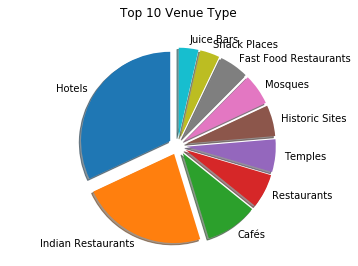

,category,VenueName
0,Hotels,108
1,Indian Restaurants,77
2,Cafés,32
3,Restaurants,21
4,Temples,20
5,Historic Sites,19
6,Mosques,19
7,Fast Food Restaurants,18
8,Snack Places,12
9,Juice Bars,12


In [56]:
# Check top 10 most frequently occuring venue type
top_10_venue = India_city_venues.groupby('category')['VenueName'].count().sort_values(ascending=False)[:10].reset_index()
labels = top_10_venue['category']
sizes  = top_10_venue['VenueName']
explode = [.1] * 10
# Plot
plt.title("Top 10 Venue Type\n")
ax1 = plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90)
plt.axis('equal')
plt.show()
top_10_venue

##### Conclusion 2: Most of the venue types are Hotel, Indian Restaurants

In [57]:
#Cities with highest mean score rating (given rating)
score_city = India_city_venues.groupby(['City'])['score'].mean().sort_values(ascending=False).reset_index()
score_city

,City,score
0,Chennai,7.757143
1,Varanasi,7.400000
2,Udaipur,7.172857
3,Agra,7.090909
4,Darjeeling,7.000000
5,Amritsar,6.920755
6,Mumbai,6.918750
7,Shimla,6.918182
8,Jaipur,6.908000
9,Khajjiar,6.828571


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


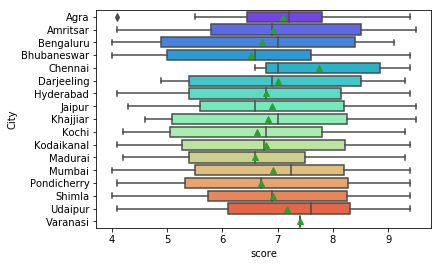

In [58]:
# Boxplot for each city

sns.boxplot(x='score',y='City',data=India_city_venues,palette='rainbow', showmeans=True, 
            order = sorted(India_city_venues.City.unique()))

#### As per the box plot, cities Chennai, Varanasi, Udaipur, Agra and Darjeeling are the top 5 cities to visit.

### We can get the venue count for each city based on the traveller's choice

In [59]:
# Here we have selected Bengaluru and find the different venue counts in Bengaluru.
City_bengaluru_venues = India_city_venues[(India_city_venues['City'] == 'Bengaluru')]
City_bengaluru_count = City_bengaluru_venues.groupby('Primary_category')['VenueName'].count().sort_values(ascending=False)[:10].reset_index()
City_bengaluru_count

,Primary_category,VenueName
0,Food,14
1,Travel,6
2,Historic Sites,1
